In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from model_definitions import CNN, ResNetModel, PatchSelection, DIF, UFD


In [2]:
MODEL_PATH = "newly_trained_model"
TEST_DATA_PATH = os.path.normpath("D:/AI_Image_Detection_WebApp/new_preprocessed_dataset/test")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
CLASSIFICATION_REPORT_FILE = "hybrid_classification_report.txt"
PREDICTION_OUTPUT_FILE = "hybrid_model_predictions.txt"
CONFUSION_MATRIX_FILE = "hybrid_confusion_matrix.png"


In [3]:
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(f"Test data path does not exist: {TEST_DATA_PATH}")


In [4]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

In [5]:
test_dataset = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['fake', 'real']


In [6]:
MODEL_PATH = r"D:\AI_Image_Detection_WebApp\src\newly_trained_model"  # Absolute path

def load_model(model_class, file_name):
    model = model_class().to(DEVICE)
    model_file_path = os.path.join(MODEL_PATH, file_name + ".pth")  # Add .pth extension
    if not os.path.exists(model_file_path):
        raise FileNotFoundError(f"Model file not found: {model_file_path}")
    model.load_state_dict(torch.load(model_file_path, map_location=DEVICE))
    model.eval()
    return model

# Load all models with updated filenames
cnn_model = load_model(CNN, "CNN")
resnet_model = load_model(ResNetModel, "ResNetModel")
patch_model = load_model(PatchSelection, "PatchSelection")
dif_model = load_model(DIF, "DIF")
ufd_model = load_model(UFD, "UFD")

models = [cnn_model, resnet_model, patch_model, dif_model, ufd_model]
model_names = ["CNN", "ResNet", "Patch", "DIF", "UFD"]


d:\AI_Image_Detection_WebApp\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AI_Image_Detection_WebApp\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
weights = [1.0, 1.0, 1.0, 1.0, 1.0]  # Equal weights for now


In [8]:
all_preds = []
all_labels = []
output_lines = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        votes = []

        # Collect predictions from all models
        for model in models:
            outputs = model(images)
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            votes.append(preds.cpu().numpy())

        votes = np.array(votes)  # Shape: [num_models, batch_size]
        weighted_votes = np.zeros((votes.shape[1], 2))  # [batch_size, num_classes]

        # Apply weighted voting
        for i in range(len(models)):
            for j in range(votes.shape[1]):
                weighted_votes[j][votes[i][j]] += weights[i]

        final_preds = np.argmax(weighted_votes, axis=1)

        # Store predictions and ground truths
        all_preds.extend(final_preds)
        all_labels.extend(labels.cpu().numpy())

        # Save predictions with filenames
        for i in range(len(final_preds)):
            img_idx = len(all_preds) - len(final_preds) + i
            img_path = test_dataset.samples[img_idx][0]
            true_class = class_names[labels[i]]
            predicted_class = class_names[final_preds[i]]
            output_lines.append(f"{img_path} | Actual: {true_class} | Predicted: {predicted_class}\n")


In [9]:
with open(PREDICTION_OUTPUT_FILE, "w", encoding="utf-8") as f:
    f.writelines(output_lines)


In [10]:
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

with open(CLASSIFICATION_REPORT_FILE, "w", encoding="utf-8") as f:
    f.write(report)


Classification Report:
               precision    recall  f1-score   support

        fake       0.94      0.78      0.85     10190
        real       0.86      0.96      0.91     14000

    accuracy                           0.89     24190
   macro avg       0.90      0.87      0.88     24190
weighted avg       0.89      0.89      0.88     24190



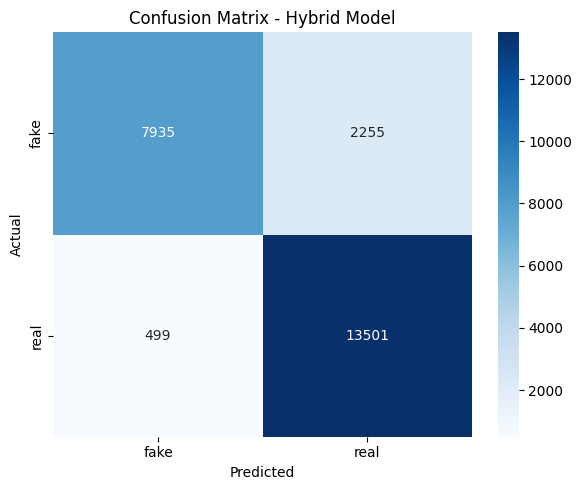

In [13]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.tight_layout()
plt.savefig(CONFUSION_MATRIX_FILE)
plt.show()